In [10]:
from glob import glob
from scipy import optimize
from waveform_tools import ScopeWaveform
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib widget

In [2]:
infpns = glob('20220321_data_58V/*.csv')

def trigger_intervals_one_file(infpn):
    wf = ScopeWaveform(infpn)
    print(wf.waveform_peaks(9e-3))
    print(wf.df.head())
    wf.draw_waveform()

[(-4.498e-06, 0.009600000381373548), (2.68e-08, 0.01800000068137355), (5.6824e-06, 0.01080000038137355), (7.2068e-06, 0.01440000058137355)]
         info_name         value    units      time  waveform_value  \
0    Record Length  1.000000e+05   Points -0.000008          0.0012   
1  Sample Interval  2.000000e-10        s -0.000008          0.0000   
2    Trigger Point  3.998000e+04  Samples -0.000008          0.0012   
3     Trigger Time  2.839683e-11        s -0.000008          0.0024   
4              NaN           NaN      NaN -0.000008          0.0012   

   partial_integral  is_peak  
0            0.0012    False  
1            0.0012    False  
2            0.0024    False  
3            0.0048    False  
4            0.0060    False  
20220321_data_58V/sample2.csv waveform_value


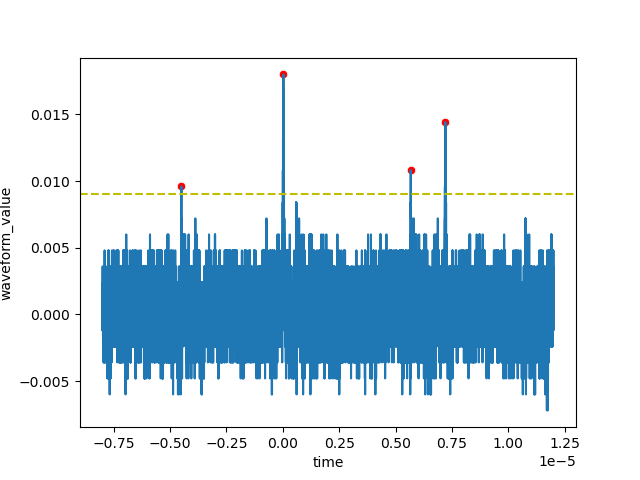

In [3]:
trigger_intervals_one_file(infpns[1])

20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv waveform_value_moving_average_100
20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv waveform_value_moving_average_200
20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv waveform_value


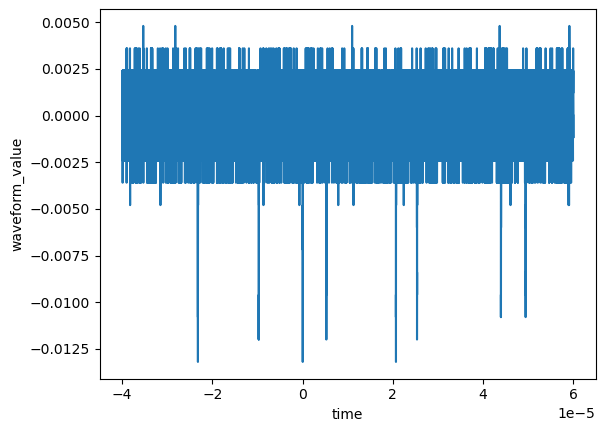

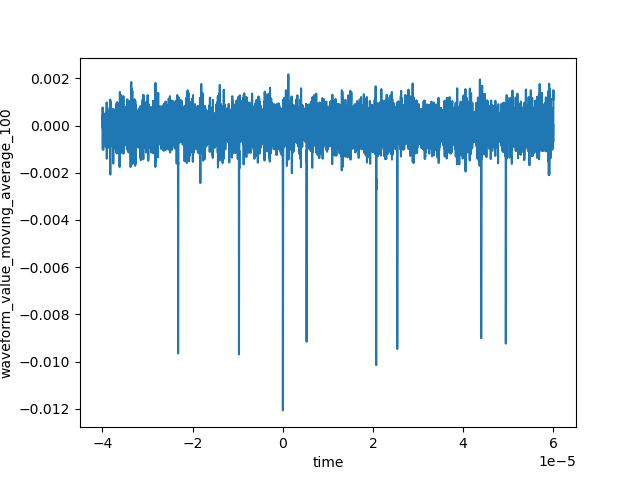

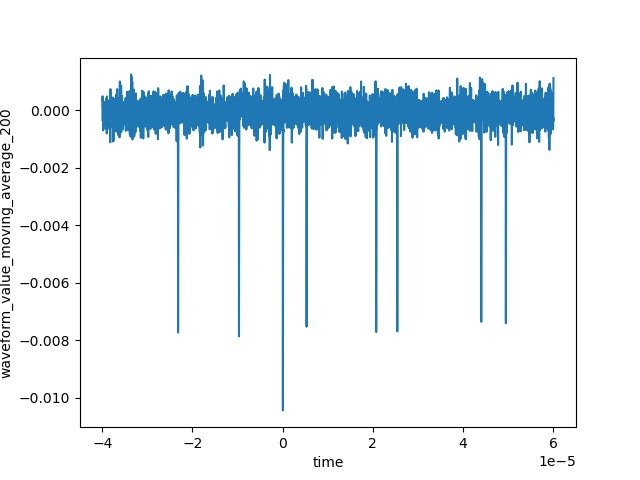

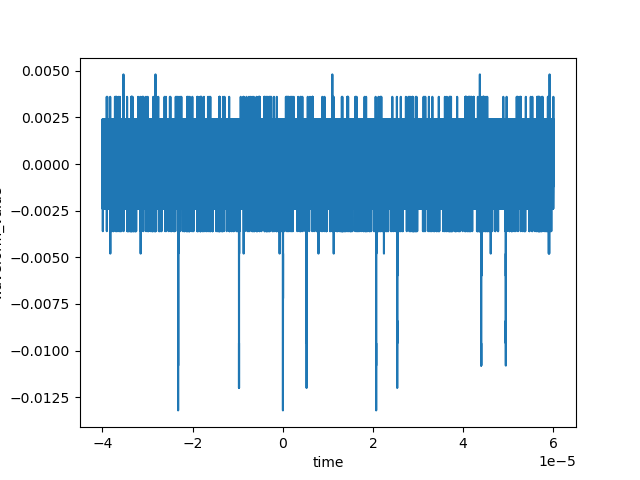

In [4]:
wf = ScopeWaveform('20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv')
wf.add_moving_average(100)
wf.draw_waveform(100)
wf.add_moving_average(200)
wf.draw_waveform(200)
wf.draw_waveform()

20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv waveform_value_moving_average_200
96329.83334938831


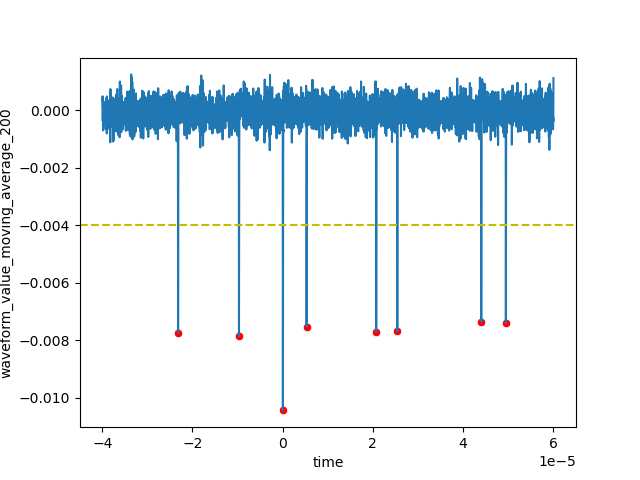

In [5]:
def likelihood_func(b):
    return lambda a: math.pow(a, len(b))*math.exp(-a*sum(b))
wf.waveform_peaks(0.007, polarity=-1)
interarrivals = wf.waveform_peak_time_diffs(0.004, polarity=-1, window_size=200)
wf.draw_waveform(window_size=200)
le = likelihood_func(interarrivals)
r_min = len(interarrivals)/sum(interarrivals)
print(r_min)
# le(r_min)
# t = np.linspace(0, 2*r_min, 100)
# plt.plot(t, le(t), color='red')

64355.79865671285 137463.60896390214


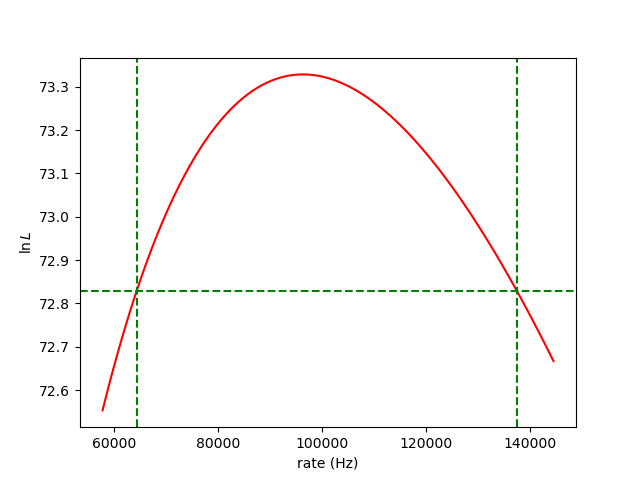

In [6]:
def log_likelihood_func(b):
    return lambda a: len(b)*math.log(a)-a*sum(b)
llf = log_likelihood_func(interarrivals)
llf_vec = np.vectorize(llf)
r_best = len(interarrivals)/sum(interarrivals)

# the 1-sigma boundaries are obtained by the intersection of the llf curve
# with the horizontal line of value llf(best_fit)-0.5
llf_1sigma = llf(r_best)-.5
r_lb = optimize.brentq(lambda x: llf(x)-llf_1sigma, .1*r_best, r_best)
r_ub = optimize.brentq(lambda x: llf(x)-llf_1sigma, r_best, 10*r_best)
print(r_lb, r_ub)

t = np.linspace(.6*r_best, 1.5*r_best, 100)
plt.clf()
plt.plot(t, llf_vec(t), color='red')
plt.axhline(y=llf_1sigma, color='g', linestyle='--')
plt.axvline(x=r_lb, color='g', linestyle='--')
plt.axvline(x=r_ub, color='g', linestyle='--')
plt.ylabel('$\ln L$')
plt.xlabel('rate (Hz)')
plt.show()

20220321_data_58V/sample1.csv waveform_value_moving_average_200
20220321_data_58V/sample2.csv waveform_value_moving_average_200
20220321_data_58V/sample3.csv waveform_value_moving_average_200
20220321_data_58V/sample4.csv waveform_value_moving_average_200
20220321_data_58V/sample5.csv waveform_value_moving_average_200
20220321_data_58V/sample6.csv waveform_value_moving_average_200
20220321_data_58V/sample7.csv waveform_value_moving_average_200
20220321_data_58V/sample8.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_diff_box_25C/sample1.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_diff_box_25C/sample2.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_diff_box_25C/sample3.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_in_box_25C/sample1.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_in_box_25C/sample2.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_in_box_25C/

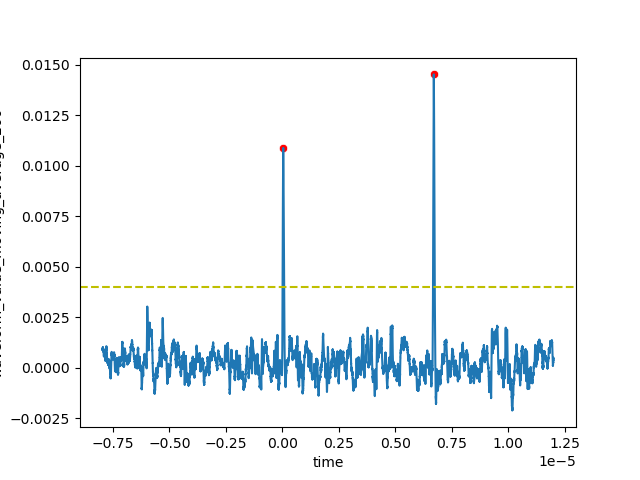

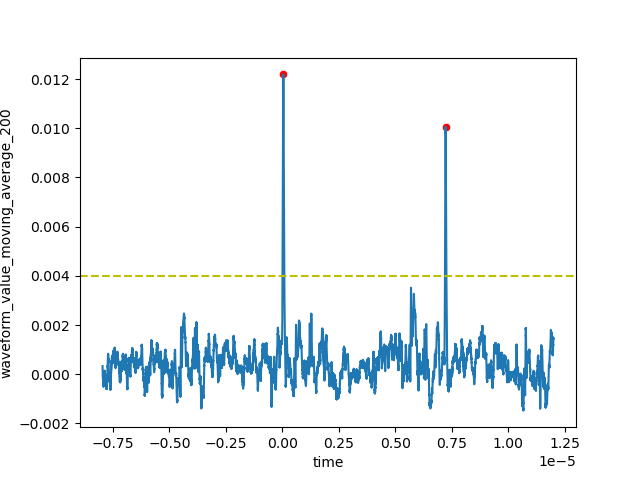

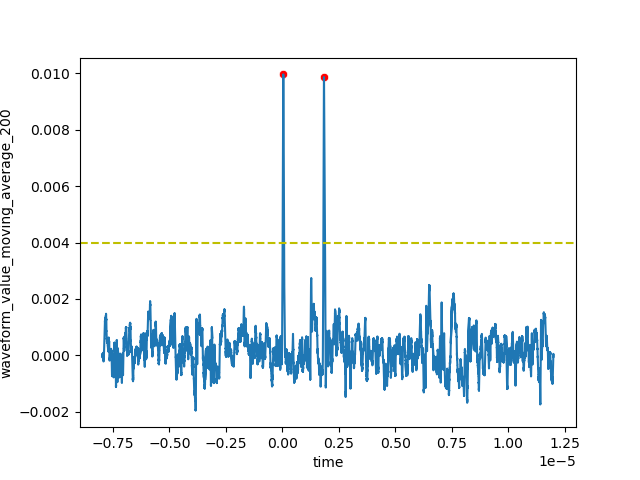

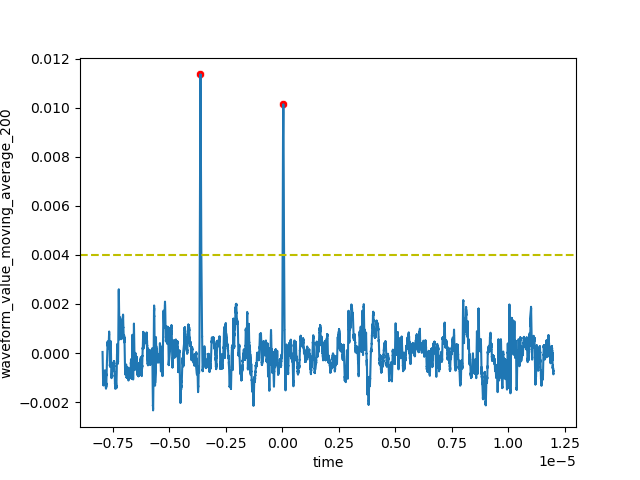

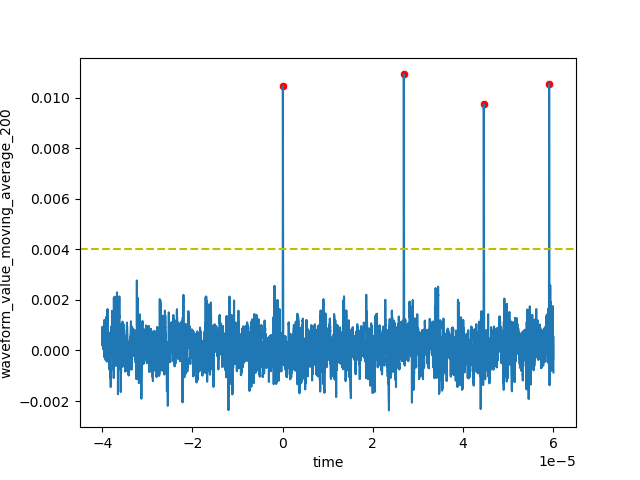

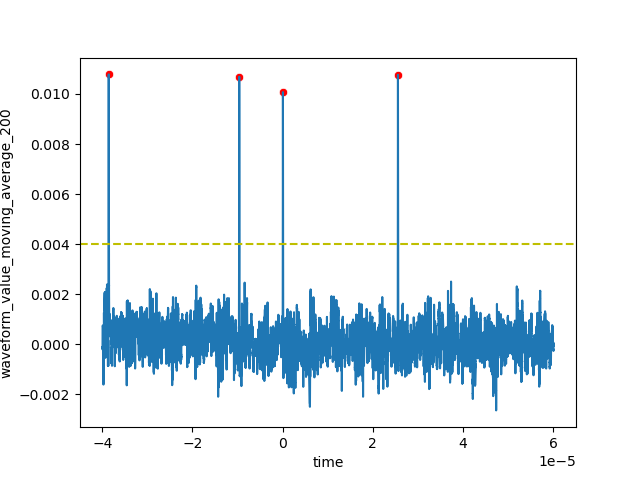

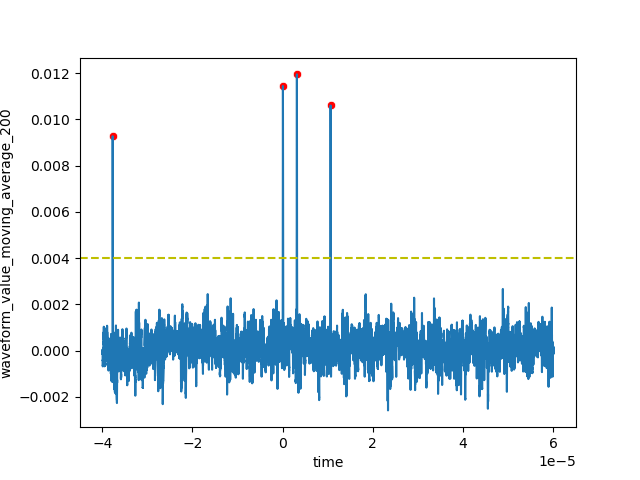

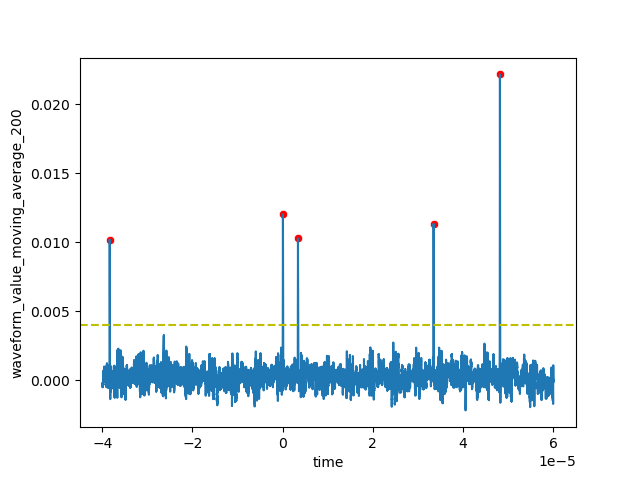

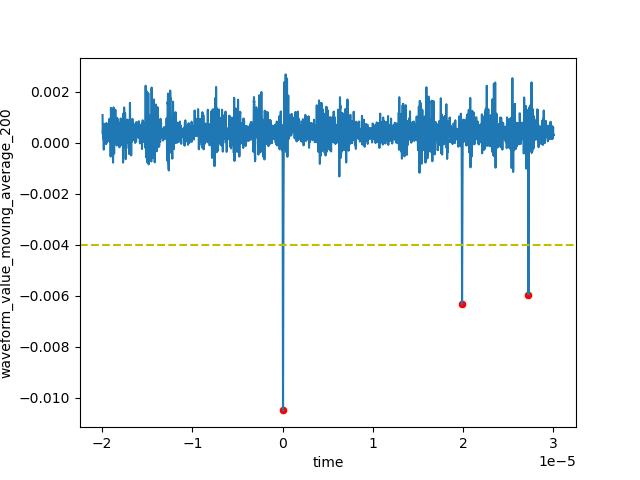

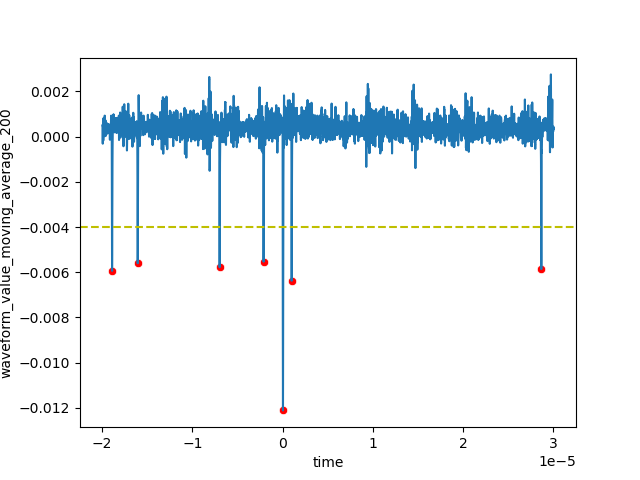

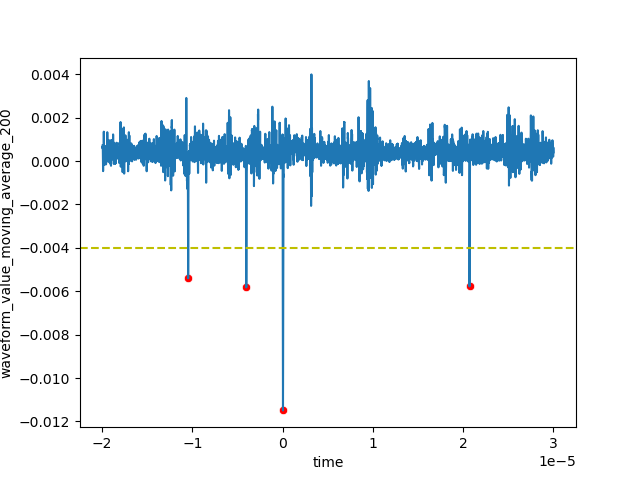

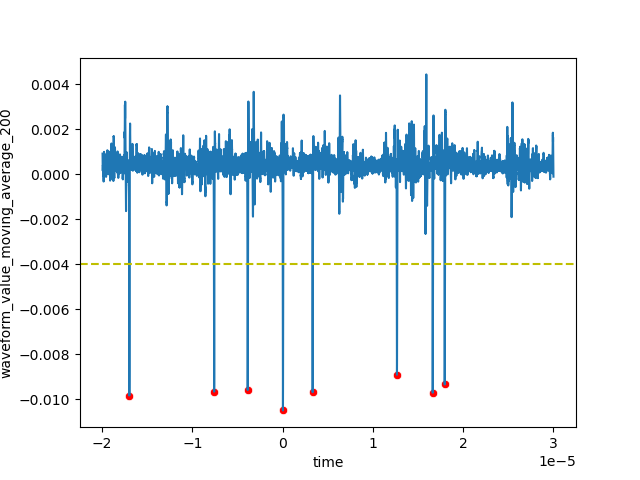

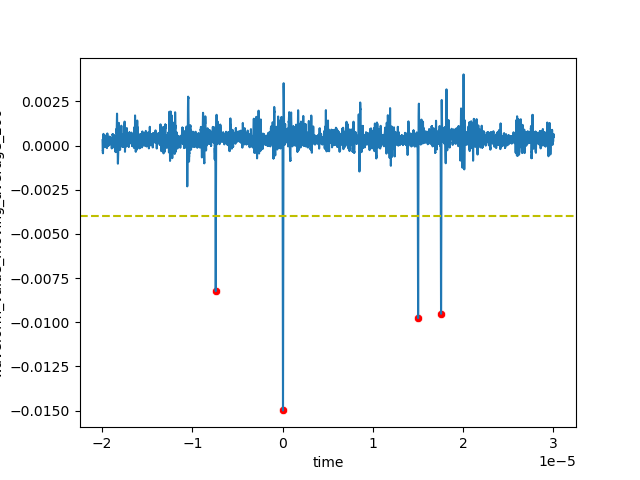

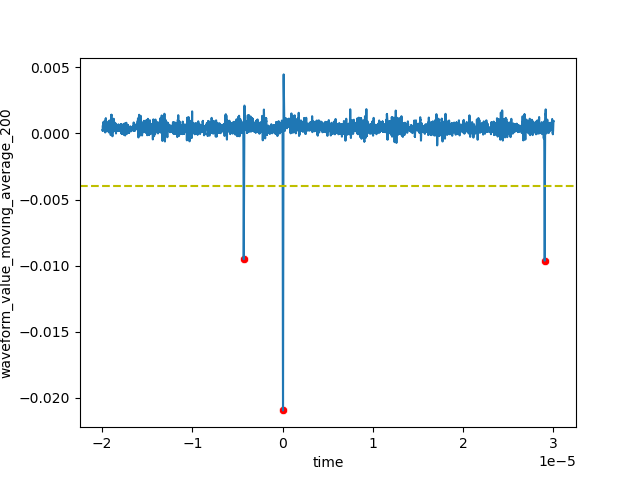

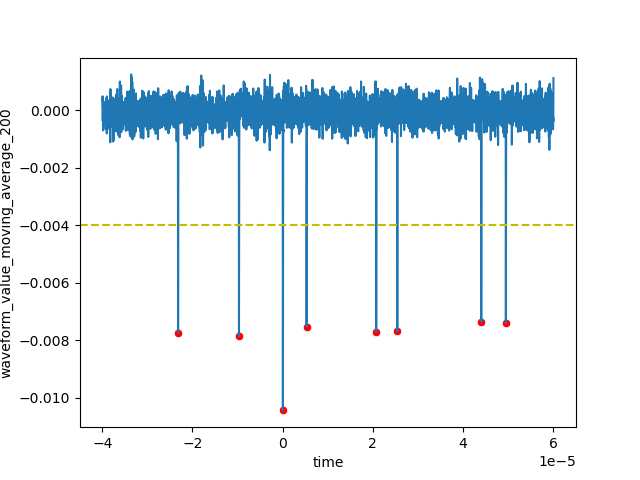

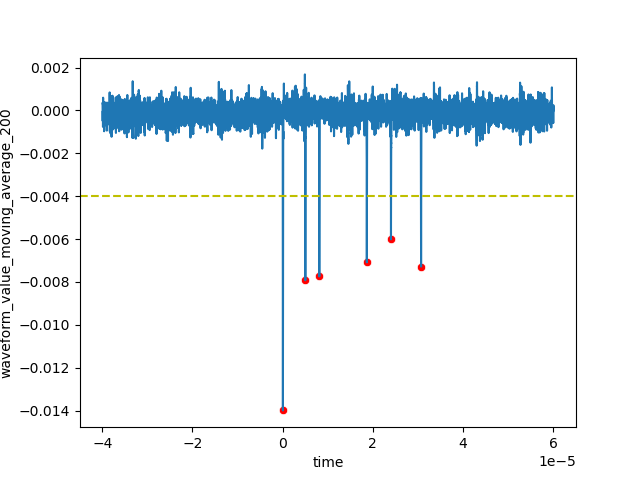

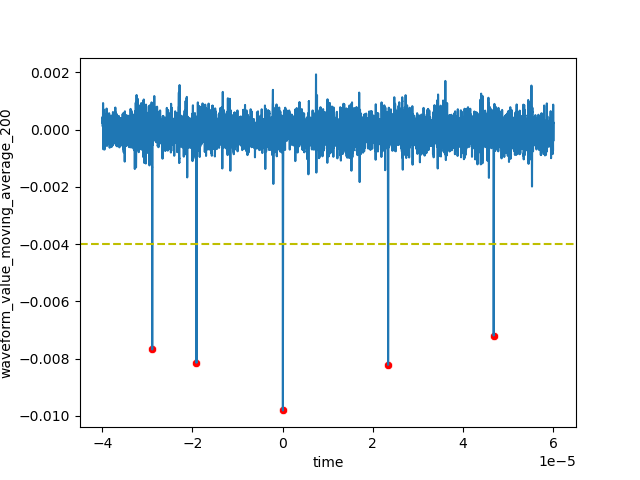

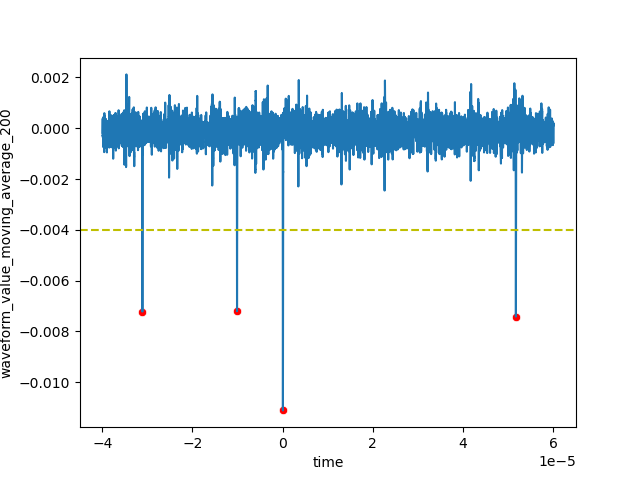

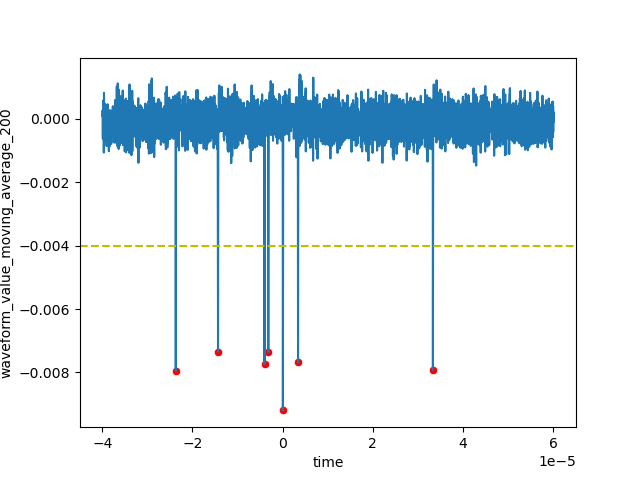

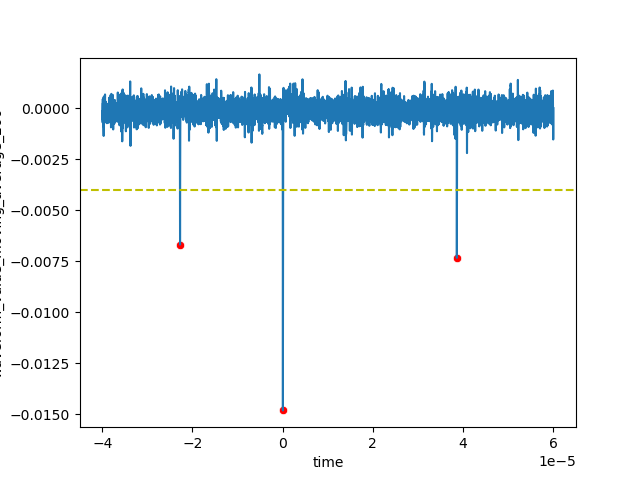

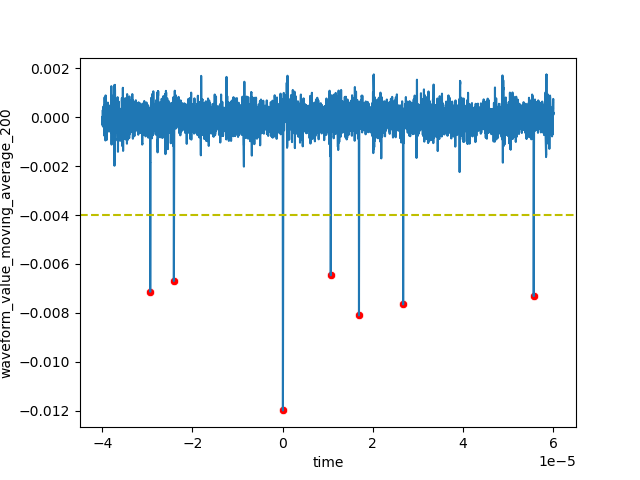

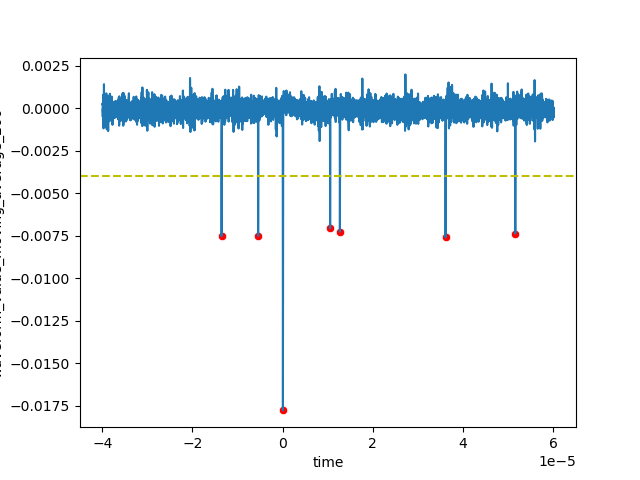

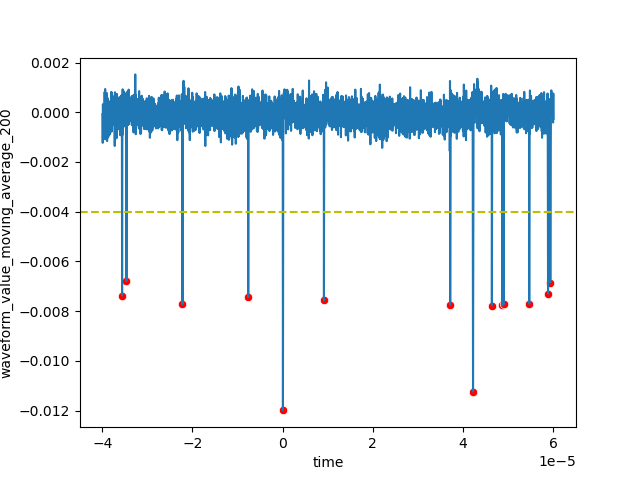

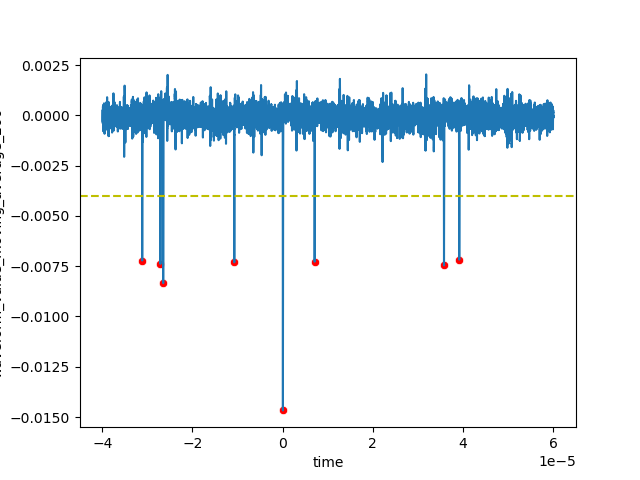

In [42]:
class rate_estimate:
    def __init__(self, infpns, polarity, threshold, window_size, name):
        self.infpns = infpns
        self.polarity = polarity
        self.threshold = threshold
        self.window_size = window_size
        self.name = name
        self.wfs = []
        self.interarrivals = []

        # load files into waveforms
        self.load_waveforms()

        # find the MPPC pulses and the interarrival times
        self.find_pulses()
    
    def load_waveforms(self):
        for infpn in self.infpns:
            self.wfs.append(ScopeWaveform(infpn))
    
    def find_pulses(self):
        for wf in self.wfs:
            self.interarrivals.extend(wf.waveform_peak_time_diffs(height_thresh=self.threshold, polarity=self.polarity, window_size=self.window_size))
            wf.draw_waveform(window_size=self.window_size)
    
    def interval_estimation(self):
        def log_likelihood_func(b):
            return lambda a: len(b)*math.log(a)-a*sum(b)
        llf = log_likelihood_func(self.interarrivals)
        llf_vec = np.vectorize(llf)
        r_best = len(self.interarrivals)/sum(self.interarrivals)

        # the 1-sigma boundaries are obtained by the intersection of the llf curve
        # with the horizontal line of value llf(best_fit)-0.5
        llf_1sigma = llf(r_best)-.5
        r_lb = optimize.brentq(lambda x: llf(x)-llf_1sigma, .1*r_best, r_best)
        r_ub = optimize.brentq(lambda x: llf(x)-llf_1sigma, r_best, 10*r_best)

        # make the llf plot
        t = np.linspace(.6*r_best, 1.5*r_best, 100)
        plt.clf()
        plt.plot(t, llf_vec(t), color='red')
        plt.axhline(y=llf_1sigma, color='g', linestyle='--')
        plt.axvline(x=r_lb, color='g', linestyle='--')
        plt.axvline(x=r_ub, color='g', linestyle='--')
        plt.ylabel('$\ln L$')
        plt.xlabel('rate (Hz)')
        plt.title(self.name)
        plt.savefig(f'plots/{os.path.dirname(self.infpns[0])}/log_likelihood_function.png')

        return r_lb, r_best, r_ub

rate_0321 = rate_estimate(glob('20220321_data_58V/*.csv'), polarity=1, threshold=0.004, window_size=200, name='20220321_fastamp_rcfilter_scope_20C_5.8Vover')
rate_0329_diff = rate_estimate(glob('20220329_rate_waveform_57V_amp_diff_box_25C/*.csv'), polarity=-1, threshold=0.004, window_size=200, name='20220329_preamp_different_box_scope_25C_4.8Vover')
rate_0329_same = rate_estimate(glob('20220329_rate_waveform_57V_amp_in_box_25C/*.csv'), polarity=-1, threshold=0.004, window_size=200, name='20220329_preamp_same_box_scope_25C_4.8Vover')
rate_0408 = rate_estimate(glob('20220408_rate_waveform_57.2V_amp_diff_box_25C/*.csv'), polarity=-1, threshold=0.004, window_size=200, name='20220408_preamp_different_box_scope_25C_5.0Vover')

In [45]:
df_all = pd.DataFrame(columns=['name', 'r_lb', 'r_best', 'r_ub'])

df_all.loc[len(df_all)] = [rate_0408.name] + list(rate_0408.interval_estimation())
df_all.loc[len(df_all)] = [rate_0329_diff.name] + list(rate_0329_diff.interval_estimation())
df_all.loc[len(df_all)] = [rate_0329_same.name] + list(rate_0329_same.interval_estimation())
df_all.loc[len(df_all)] = [rate_0321.name] + list(rate_0321.interval_estimation())

df_all.head()

,name,r_lb,r_best,r_ub
0,20220408_preamp_different_box_scope_25C_5.0Vover,74260.483625,84830.495729,96358.864042
1,20220329_preamp_different_box_scope_25C_4.8Vover,75598.289556,103843.924470,138376.782663
2,20220329_preamp_same_box_scope_25C_4.8Vover,95018.360662,128679.979325,169483.875205
3,20220321_fastamp_rcfilter_scope_20C_5.8Vover,47620.260669,61313.936008,77410.509354


/tmp/ipykernel_15332/4040220717.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


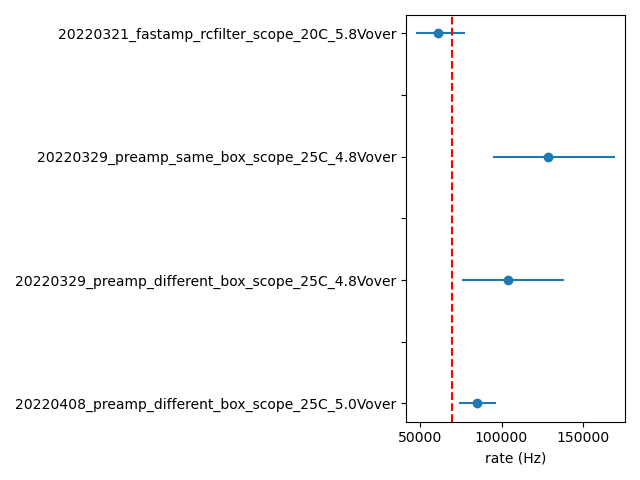

In [46]:
fig, ax = plt.subplots()
ax.errorbar(df_all.r_best, df_all.index, xerr=[df_all.r_best-df_all.r_lb, df_all.r_ub-df_all.r_best], fmt='o')
ax.axvline(x=70000, color = 'r', linestyle = '--')
ax.set_xlabel('rate (Hz)')
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = rate_0408.name
labels[3] = rate_0329_diff.name
labels[5] = rate_0329_same.name
labels[7] = rate_0321.name
ax.set_yticklabels(labels)
fig.tight_layout()